# 2.1 Dendrograms on Reduced Datasets

### Contents:
1. Install Libraries
2. Import Libraries
3. Import Datasets
4. Dendrograms on Merged Data
   - Merge Datasets
   - Select year (2020) & Scale
   - Mean Temps Dendrograms
   - Oslo/Valentia Dendrograms
   - Oslo/Stockholm Dendrograms
5. Evaluate Dendrogram Clusters & Silhouette Scores
   - All Station Mean Temp Clusters
   - Oslo/Valentia Clusters
   - Oslo/Stockholm Clusters
6. Run PCA
   - Reduce to Mean Temp Variables
   - Reduce to 2 Stations
7. Export Reduced Datasets
   - Evaluated on Oslo/Valentia set

## 1. Install Libraries

## 2. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import operator
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.pyplot import figure
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


## 3. Import Datasets

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [6]:
path = os.getcwd()
path

'/Users/kirstencurrie/ClimateWins Analysis/02 Scripts'

In [8]:
path = '/Users/kirstencurrie/ClimateWins Analysis'

In [10]:
#Read in the Mean Temp Dataset
df_temp = pd.read_parquet(os.path.join(path, '01 Datasets', '02 Prepared Data', '02 Unsupervised', 'weather_means.parquet'))
df_temp.head(1)

,DATE,MONTH,BASEL_temp_mean,BELGRADE_temp_mean,BUDAPEST_temp_mean,DEBILT_temp_mean,DUSSELDORF_temp_mean,HEATHROW_temp_mean,KASSEL_temp_mean,LJUBLJANA_temp_mean,MAASTRICHT_temp_mean,MADRID_temp_mean,MUNCHENB_temp_mean,OSLO_temp_mean,SONNBLICK_temp_mean,STOCKHOLM_temp_mean,VALENTIA_temp_mean
0,19600101,1,6.5,3.7,2.4,9.3,10.0,10.6,7.9,-0.6,9.5,7.6,6.9,4.9,-5.9,4.2,8.5


In [105]:
df_osva = pd.read_parquet(os.path.join(path, '01 Datasets', '02 Prepared Data', '02 Unsupervised', 'weather_osva.parquet'))
df_osva.shape

(22950, 23)

In [14]:
df_osst = pd.read_parquet(os.path.join(path,'01 Datasets', '02 Prepared Data', '02 Unsupervised', 'weather_osst.parquet'))
df_osst.head(1)

,DATE,MONTH,OSLO_cloud_cover,OSLO_wind_speed,OSLO_humidity,OSLO_pressure,OSLO_global_radiation,OSLO_precipitation,OSLO_snow_depth,OSLO_sunshine,OSLO_temp_mean,OSLO_temp_min,OSLO_temp_max,STOCKHOLM_cloud_cover,STOCKHOLM_pressure,STOCKHOLM_global_radiation,STOCKHOLM_precipitation,STOCKHOLM_sunshine,STOCKHOLM_temp_mean,STOCKHOLM_temp_min,STOCKHOLM_temp_max
0,19600101,1,8,4.0,0.98,0.9978,0.04,1.14,0,0.0,4.9,3.8,5.9,5,1.0114,0.05,0.32,0.0,4.2,2.2,4.9


In [107]:
df_oslo = pd.read_parquet(os.path.join(path,'01 Datasets', '02 Prepared Data', '02 Unsupervised', 'weather_oslo.parquet'))
df_oslo.head(1)

,DATE,MONTH,OSLO_cloud_cover,OSLO_wind_speed,OSLO_humidity,OSLO_pressure,OSLO_global_radiation,OSLO_precipitation,OSLO_snow_depth,OSLO_sunshine,OSLO_temp_mean,OSLO_temp_min,OSLO_temp_max
0,19600101,1,8,4.0,0.98,0.9978,0.04,1.14,0,0.0,4.9,3.8,5.9


In [16]:
#Read in Oslo Valentia Dataset
pleasant = pd.read_csv(os.path.join(path, '01 Datasets', '01 Original Data', 'Dataset-Answers-Weather_Prediction_Pleasant_Weather.csv'))
pleasant.head(1)

,DATE,BASEL_pleasant_weather,BELGRADE_pleasant_weather,BUDAPEST_pleasant_weather,DEBILT_pleasant_weather,DUSSELDORF_pleasant_weather,HEATHROW_pleasant_weather,KASSEL_pleasant_weather,LJUBLJANA_pleasant_weather,MAASTRICHT_pleasant_weather,MADRID_pleasant_weather,MUNCHENB_pleasant_weather,OSLO_pleasant_weather,SONNBLICK_pleasant_weather,STOCKHOLM_pleasant_weather,VALENTIA_pleasant_weather
0,19600101,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## 4. Dendrograms on Reduced Data

#### Select Year (2020) & Scale

In [154]:
#Convert Date column to date/time column
df_temp['DATE'] = pd.to_datetime(df_temp['DATE'], format='%Y%m%d')
df_osva['DATE'] = pd.to_datetime(df_osva['DATE'], format='%Y%m%d')
df_osst['DATE'] = pd.to_datetime(df_osst['DATE'], format='%Y%m%d')
df_oslo['DATE'] = pd.to_datetime(df_oslo['DATE'], format='%Y%m%d')
pleasant['DATE'] = pd.to_datetime(pleasant['DATE'], format='%Y%m%d')

In [158]:
#Reduce your dataset to a single year
df_temp_2020 = df_temp[df_temp['DATE'].dt.year == 2020]
df_osva_2020 = df_osva[df_osva['DATE'].dt.year == 2020]
df_osst_2020 = df_osst[df_osst['DATE'].dt.year == 2020]
df_oslo_2020 = df_oslo[df_oslo['DATE'].dt.year == 2020]
pl_2020 = pleasant[pleasant['DATE'].dt.year == 2020]

In [160]:
#Drop date & month columns
df_temp_2 = df_temp_2020.drop(['DATE', 'MONTH'], axis=1)
df_osva_2 = df_osva_2020.drop(['DATE', 'MONTH'], axis=1)
df_osst_2 = df_osst_2020.drop(['DATE', 'MONTH'], axis=1)
df_oslo_2 = df_oslo_2020.drop(['DATE', 'MONTH'], axis=1)
pl_2 = pl_2020.drop(['DATE'], axis=1)

In [138]:
#create scaler object
scaler = StandardScaler()

In [140]:
#Scale weather data
temp_scaled = pd.DataFrame(scaler.fit_transform(df_temp_2), 
                         columns=df_temp_2.columns,
                         index=df_temp_2.index)

osva_scaled = pd.DataFrame(scaler.fit_transform(df_osva_2), 
                         columns=df_osva_2.columns,
                         index=df_osva_2.index)

osst_scaled = pd.DataFrame(scaler.fit_transform(df_osst_2), 
                         columns=df_osst_2.columns,
                         index=df_osst_2.index)
oslo_scaled = pd.DataFrame(scaler.fit_transform(df_oslo_2),
                           columns=df_oslo_2.columns,
                           index=df_oslo_2.index)

#### Mean Temps Dendrograms

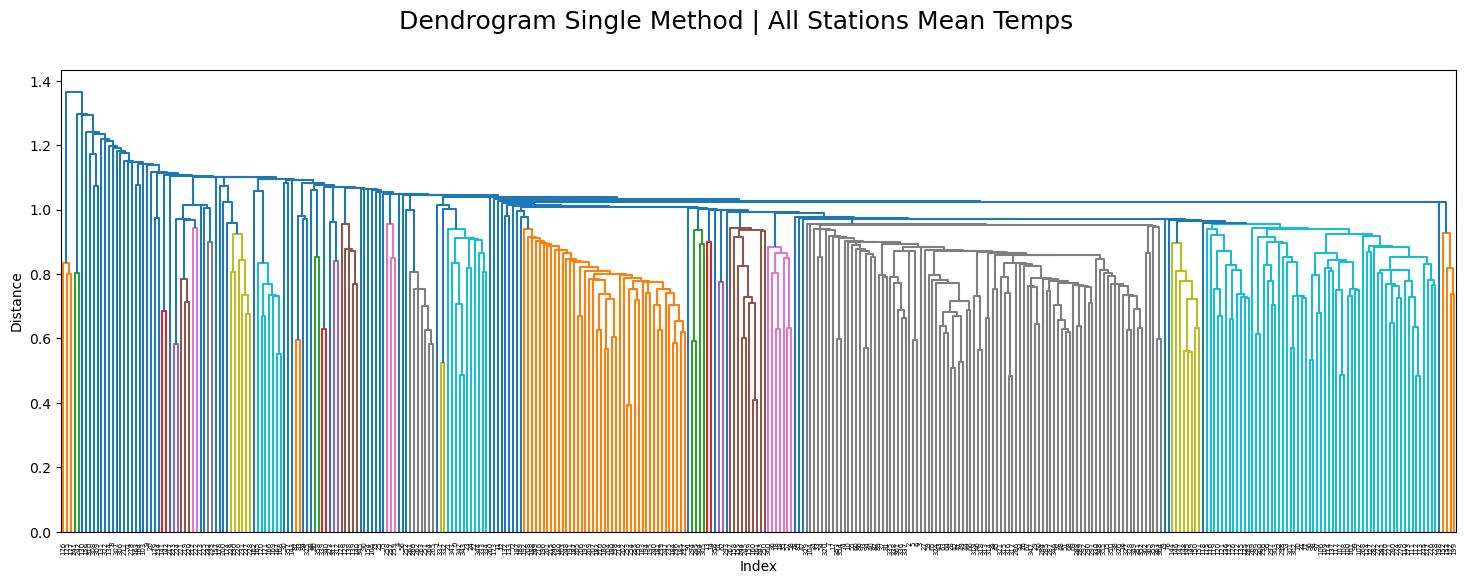

In [38]:
distance_single_temp = linkage(temp_scaled,method="single")
plt.figure(figsize=(18,6))
dendrogram(distance_single_temp, leaf_rotation=90)
plt.xlabel('Index')
plt.ylabel('Distance')
plt.suptitle("Dendrogram Single Method | All Stations Mean Temps",fontsize=18)
plt.show()

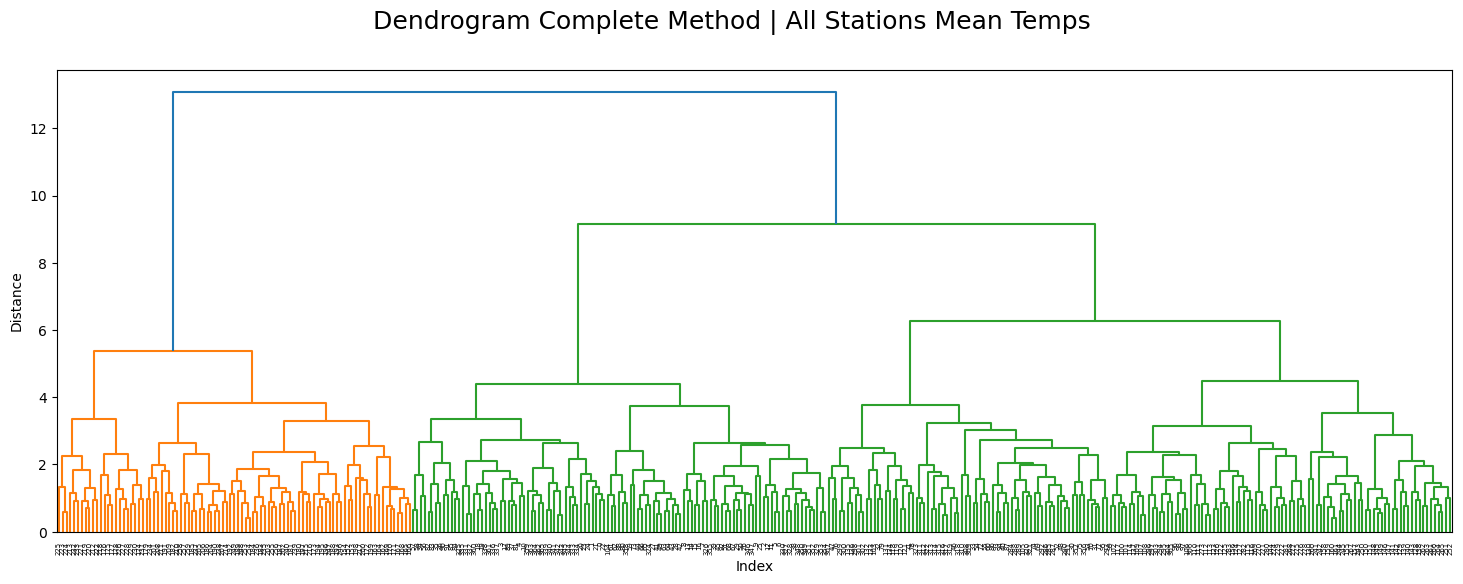

In [40]:
distance_complete_temp = linkage(temp_scaled,method="complete")
plt.figure(figsize=(18,6))
dendrogram(distance_complete_temp, leaf_rotation=90)
plt.xlabel('Index')
plt.ylabel('Distance')
plt.suptitle("Dendrogram Complete Method | All Stations Mean Temps",fontsize=18)
plt.show()

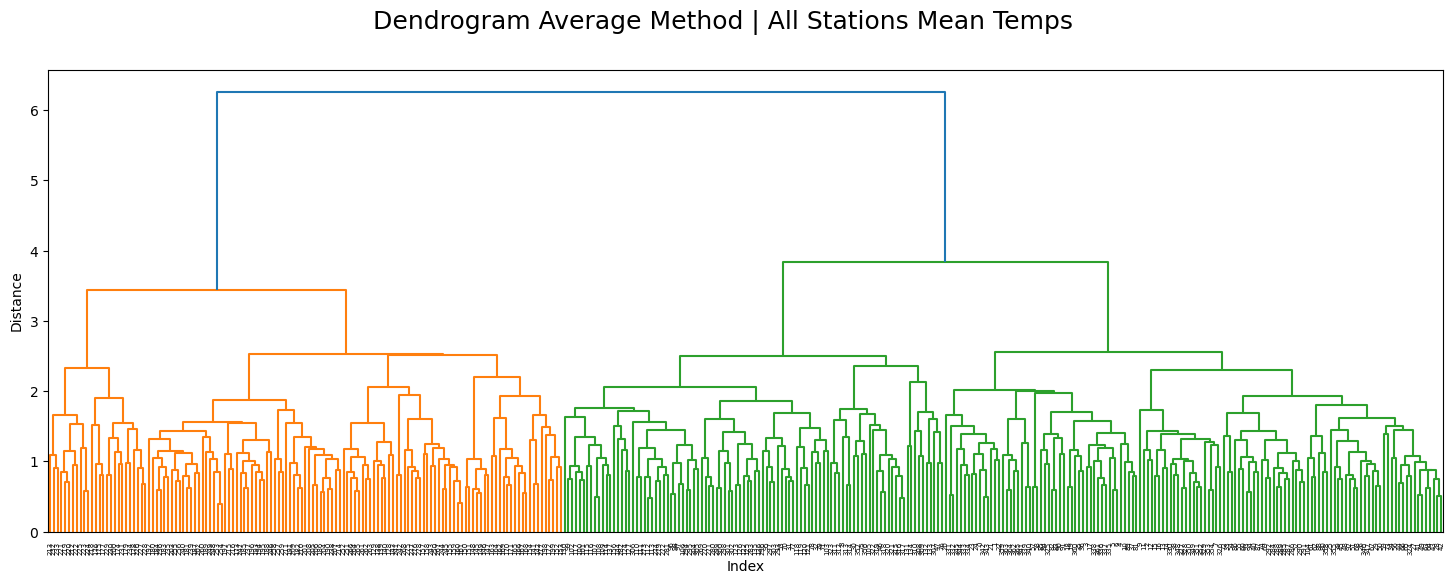

In [42]:
distance_average_temp = linkage(temp_scaled,method="average")
plt.figure(figsize=(18,6))
dendrogram(distance_average_temp, leaf_rotation=90)
plt.xlabel('Index')
plt.ylabel('Distance')
plt.suptitle("Dendrogram Average Method | All Stations Mean Temps",fontsize=18)
plt.show()

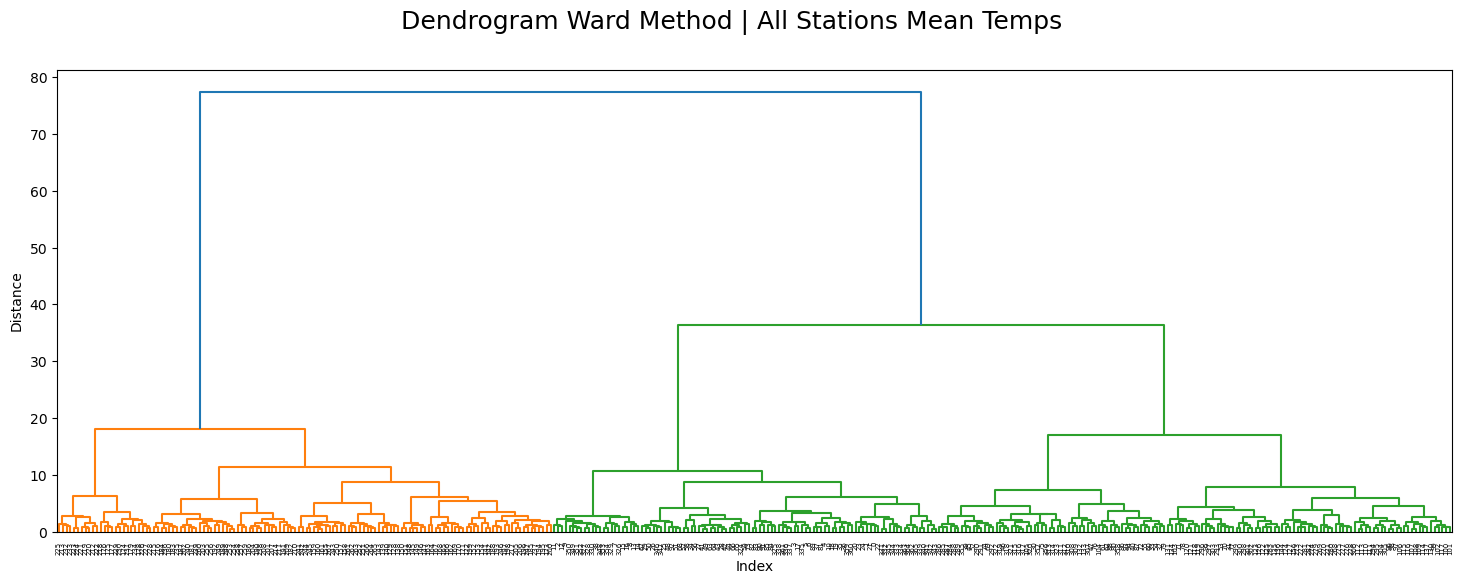

In [44]:
distance_ward_temp = linkage(temp_scaled,method="ward")
plt.figure(figsize=(18,6))
dendrogram(distance_ward_temp, leaf_rotation=90)
plt.xlabel('Index')
plt.ylabel('Distance')
plt.suptitle("Dendrogram Ward Method | All Stations Mean Temps",fontsize=18)
plt.show()

#### Oslo/Valentia Dendrograms

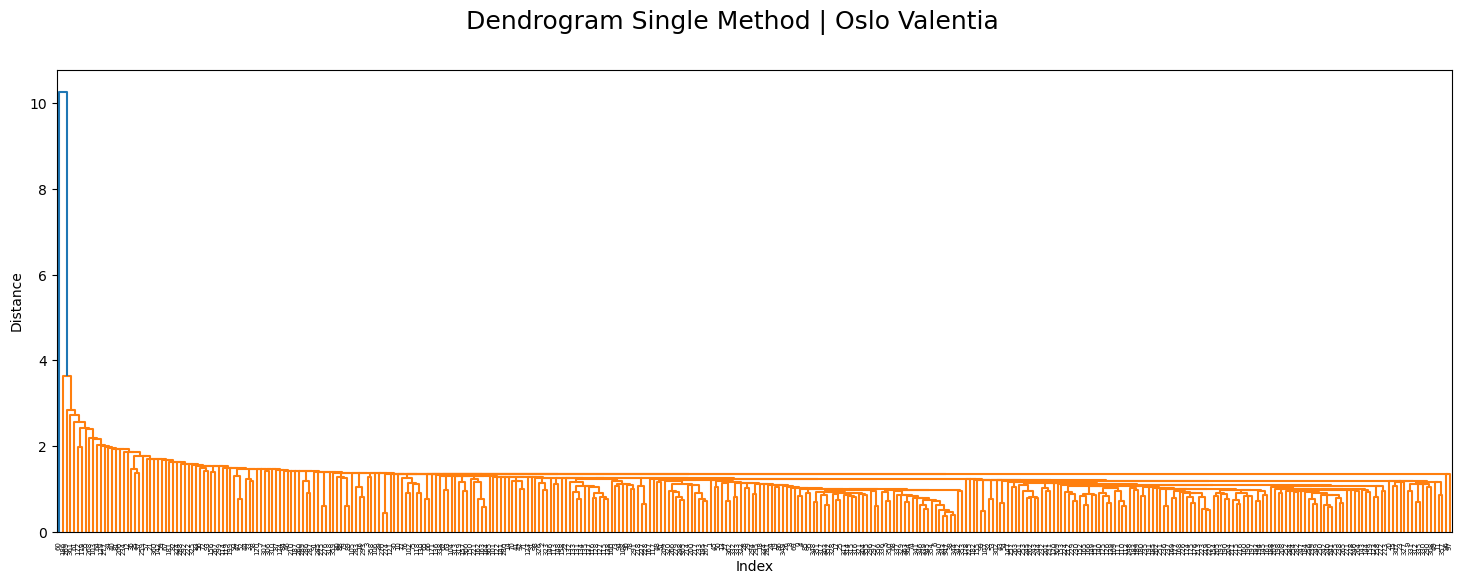

In [46]:
distance_single_osva = linkage(osva_scaled,method="single")
plt.figure(figsize=(18,6))
dendrogram(distance_single_osva, leaf_rotation=90)
plt.xlabel('Index')
plt.ylabel('Distance')
plt.suptitle("Dendrogram Single Method | Oslo Valentia",fontsize=18)
plt.show()

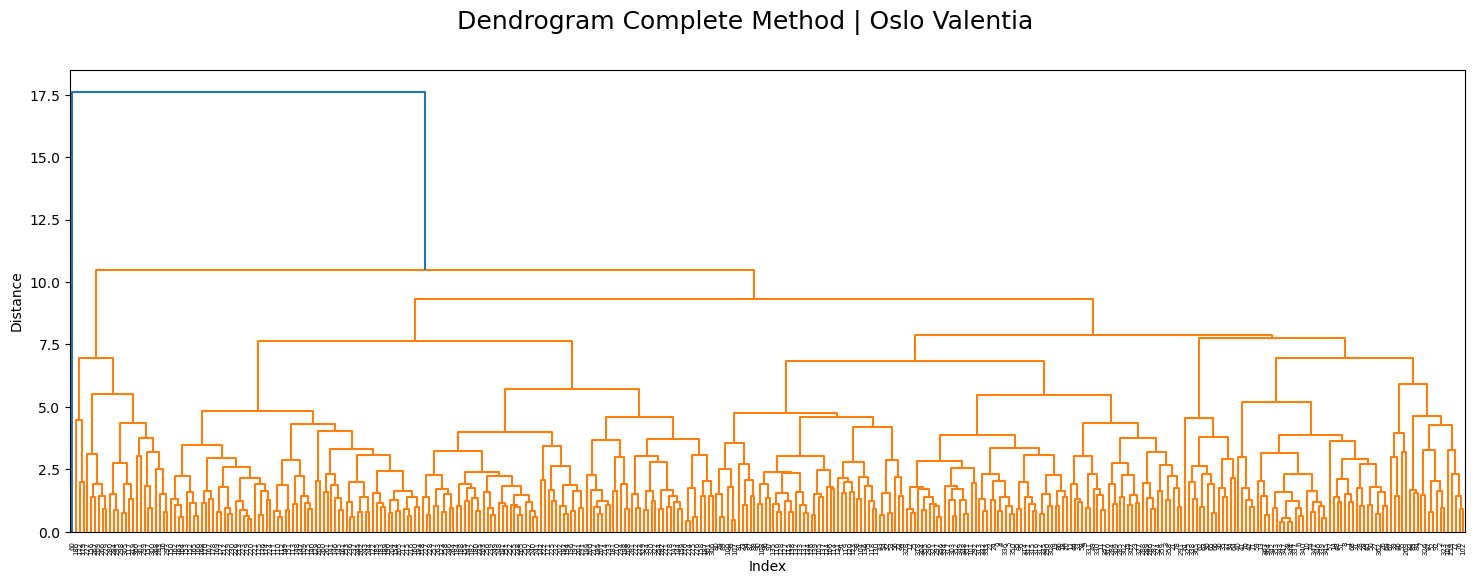

In [48]:
distance_complete_osva = linkage(osva_scaled,method="complete")
plt.figure(figsize=(18,6))
dendrogram(distance_complete_osva, leaf_rotation=90)
plt.xlabel('Index')
plt.ylabel('Distance')
plt.suptitle("Dendrogram Complete Method | Oslo Valentia",fontsize=18)
plt.show()

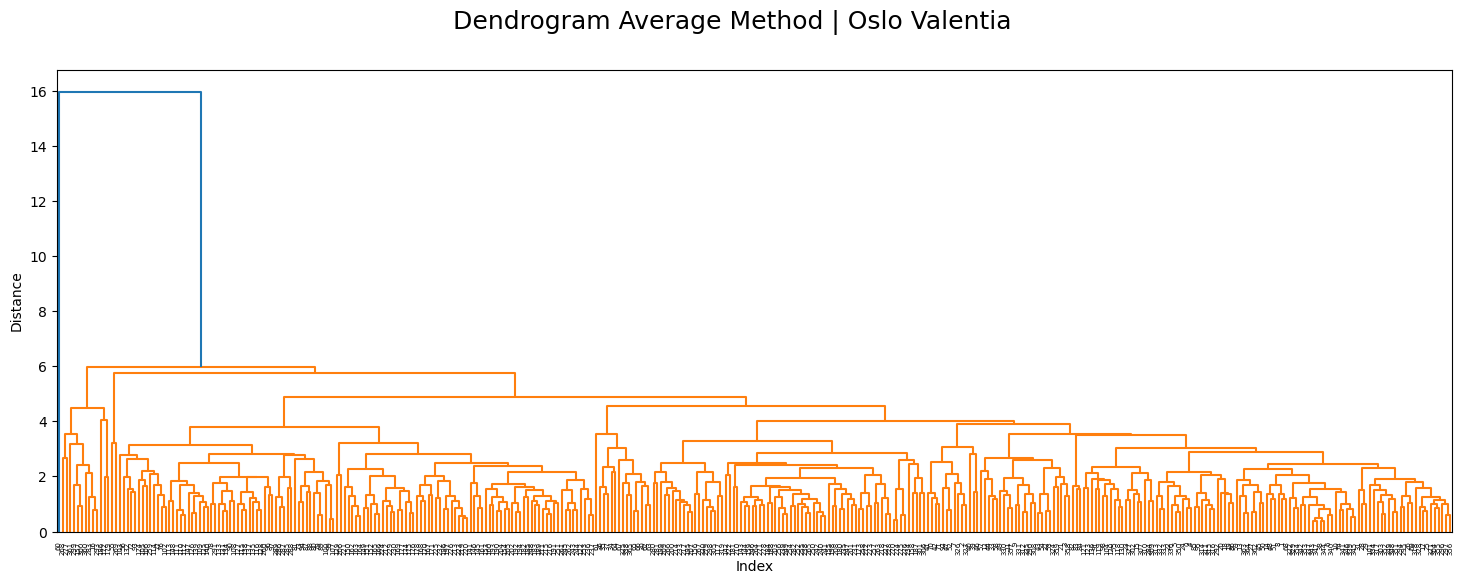

In [50]:
distance_average_osva = linkage(osva_scaled,method="average")
plt.figure(figsize=(18,6))
dendrogram(distance_average_osva, leaf_rotation=90)
plt.xlabel('Index')
plt.ylabel('Distance')
plt.suptitle("Dendrogram Average Method | Oslo Valentia",fontsize=18)
plt.show()

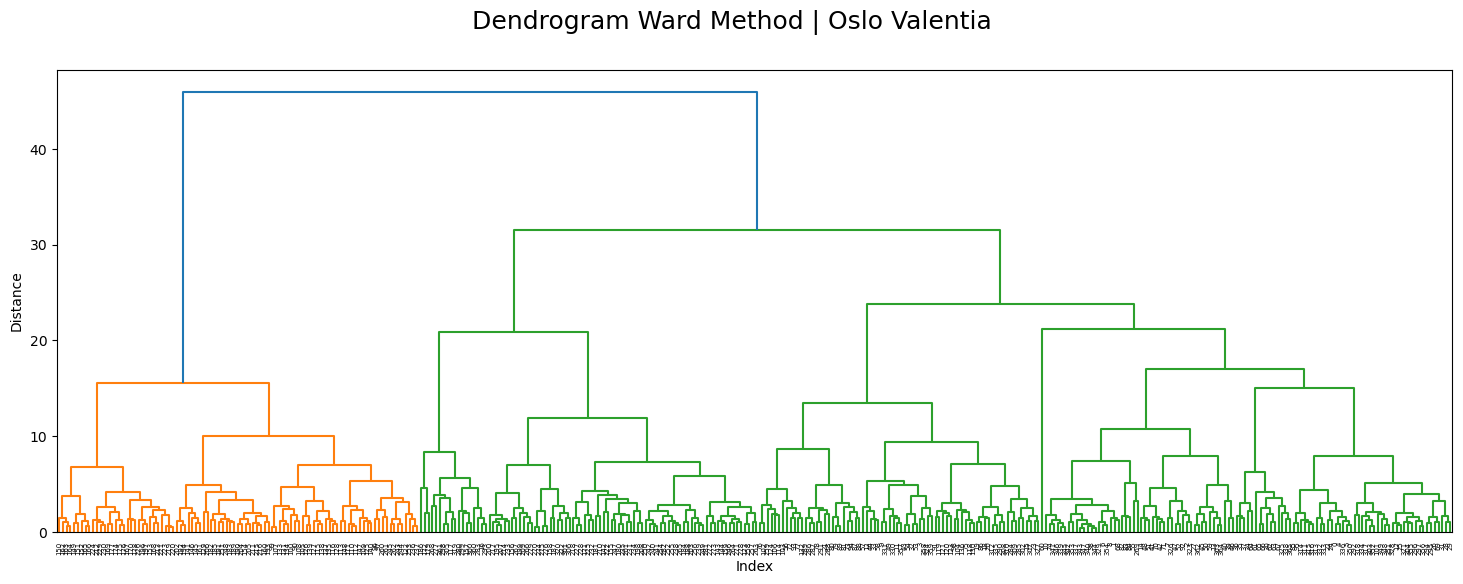

In [52]:
distance_ward_osva = linkage(osva_scaled,method="ward")
plt.figure(figsize=(18,6))
dendrogram(distance_ward_osva, leaf_rotation=90)
plt.xlabel('Index')
plt.ylabel('Distance')
plt.suptitle("Dendrogram Ward Method | Oslo Valentia",fontsize=18)
plt.show()

#### Oslo/Stockholme Dendrograms

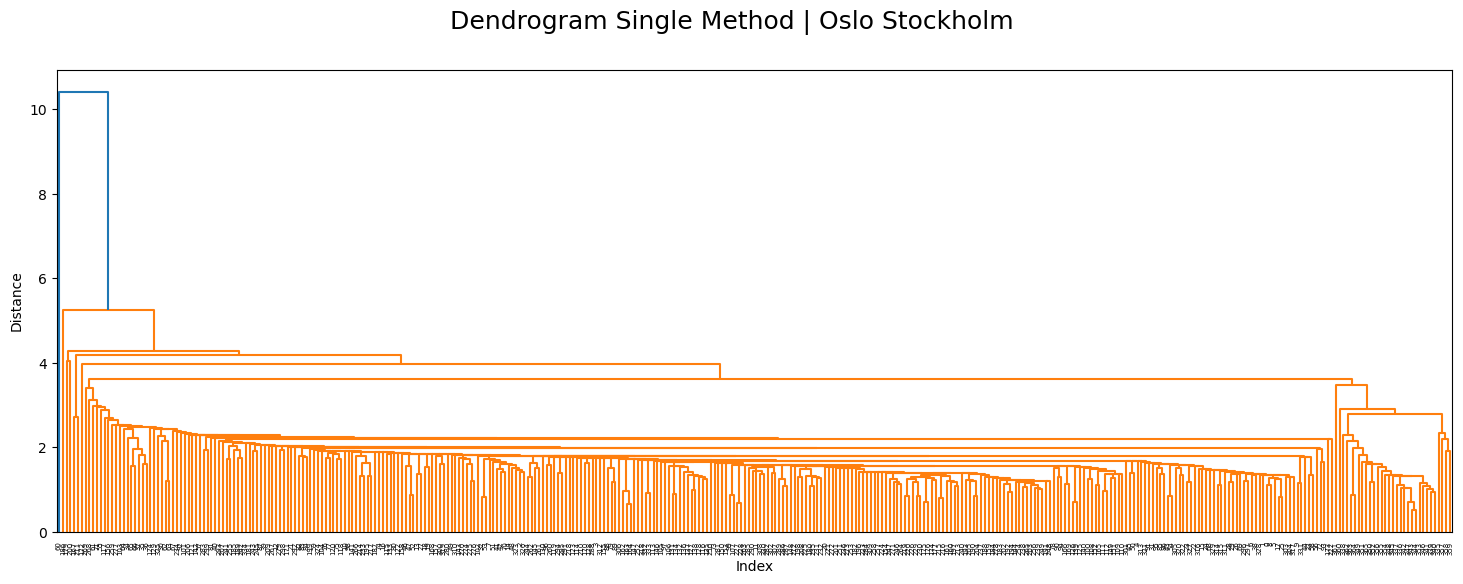

In [54]:
distance_single_osst = linkage(osst_scaled,method="single")
plt.figure(figsize=(18,6))
dendrogram(distance_single_osst, leaf_rotation=90)
plt.xlabel('Index')
plt.ylabel('Distance')
plt.suptitle("Dendrogram Single Method | Oslo Stockholm",fontsize=18)
plt.show()

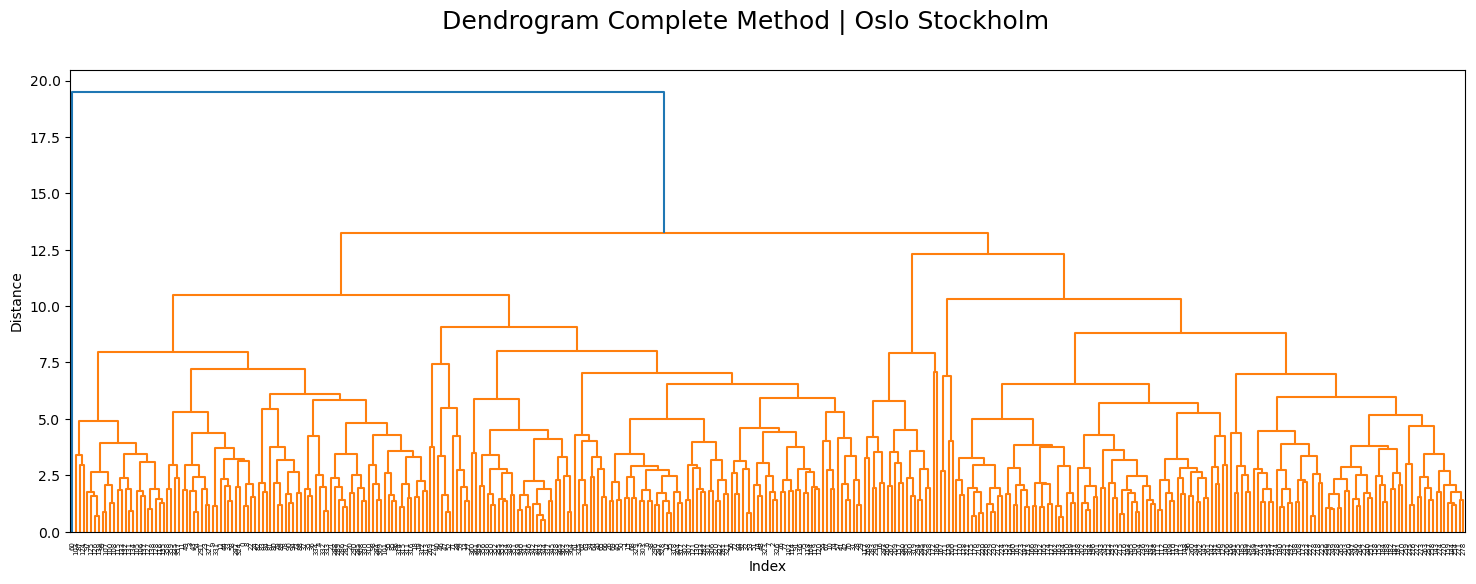

In [56]:
distance_complete_osst = linkage(osst_scaled,method="complete")
plt.figure(figsize=(18,6))
dendrogram(distance_complete_osst, leaf_rotation=90)
plt.xlabel('Index')
plt.ylabel('Distance')
plt.suptitle("Dendrogram Complete Method | Oslo Stockholm",fontsize=18)
plt.show()

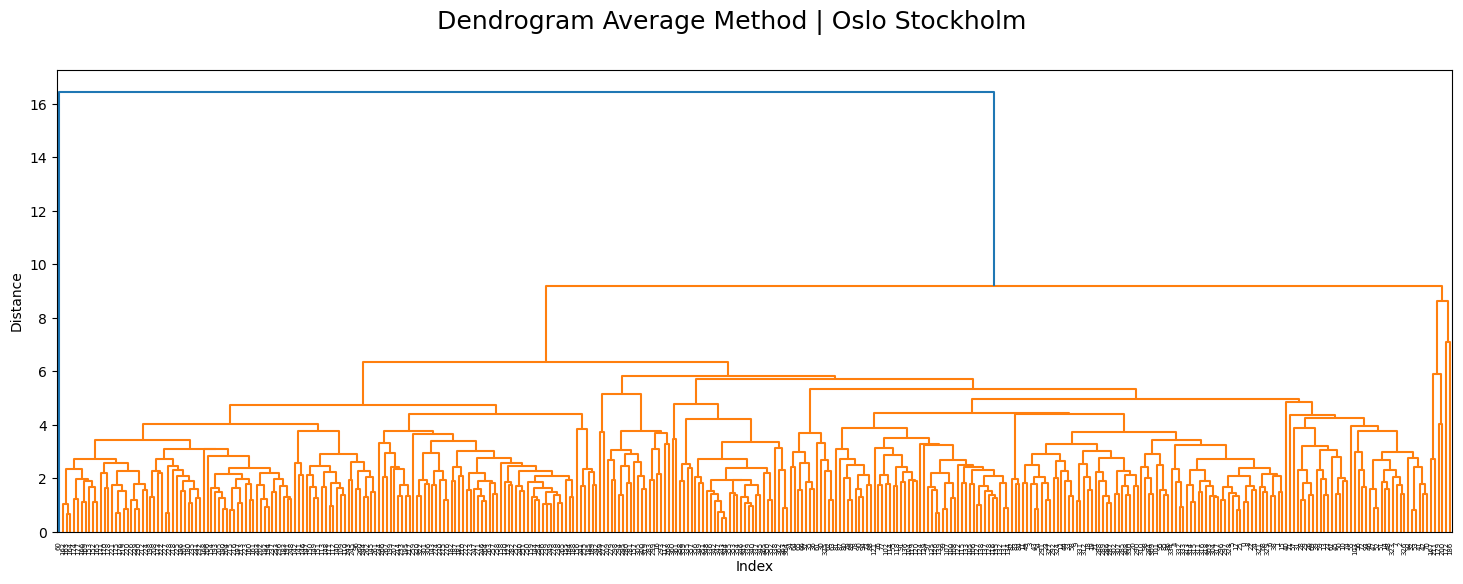

In [58]:
distance_average_osst = linkage(osst_scaled,method="average")
plt.figure(figsize=(18,6))
dendrogram(distance_average_osst, leaf_rotation=90)
plt.xlabel('Index')
plt.ylabel('Distance')
plt.suptitle("Dendrogram Average Method | Oslo Stockholm",fontsize=18)
plt.show()

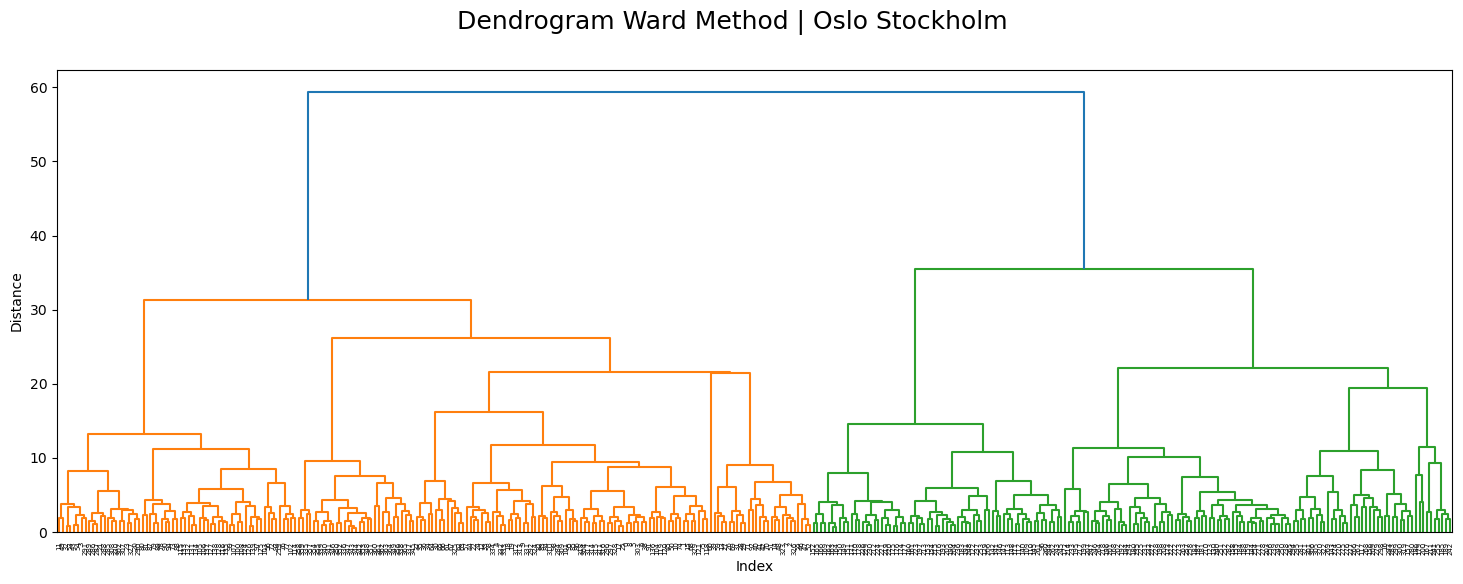

In [60]:
distance_ward_osst = linkage(osst_scaled,method="ward")
plt.figure(figsize=(18,6))
dendrogram(distance_ward_osst, leaf_rotation=90)
plt.xlabel('Index')
plt.ylabel('Distance')
plt.suptitle("Dendrogram Ward Method | Oslo Stockholm",fontsize=18)
plt.show()

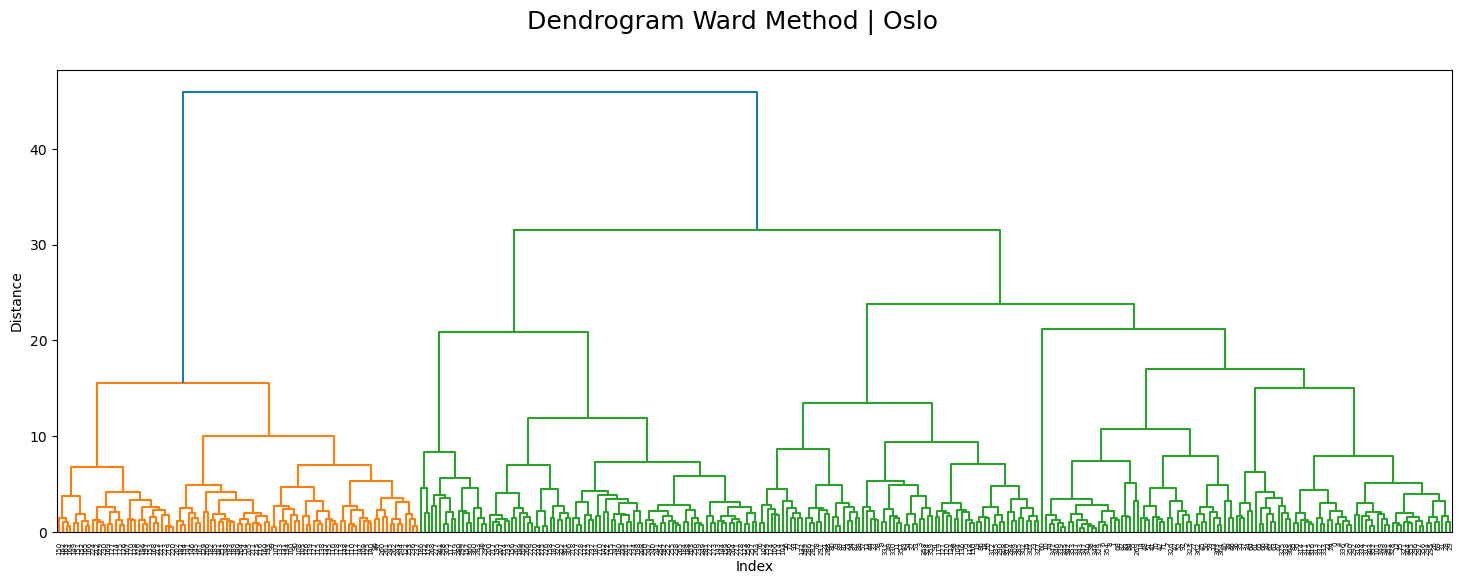

In [144]:
distance_ward_oslo = linkage(oslo_scaled,method="ward")
plt.figure(figsize=(18,6))
dendrogram(distance_ward_oslo, leaf_rotation=90)
plt.xlabel('Index')
plt.ylabel('Distance')
plt.suptitle("Dendrogram Ward Method | Oslo",fontsize=18)
plt.show()

## 5. Evaluate Dendrogram Clusters & Silhouette Scores

#### All Station Mean Temps Clusters

In [62]:
temp_scaled_SM = temp_scaled.copy()

temp_scaled_SM['clust2']=fcluster(distance_single_temp,2, criterion='maxclust')
temp_scaled_SM['clust3']=fcluster(distance_single_temp,3, criterion='maxclust')
temp_scaled_SM['clust4']=fcluster(distance_single_temp,4, criterion='maxclust')
temp_scaled_SM['clust5']=fcluster(distance_single_temp,5, criterion='maxclust')
temp_scaled_SM['clust6']=fcluster(distance_single_temp,6, criterion='maxclust')
temp_scaled_SM['clust7']=fcluster(distance_single_temp,7, criterion='maxclust')
temp_scaled_SM['clust8']=fcluster(distance_single_temp,8, criterion='maxclust')
temp_scaled_SM['clust9']=fcluster(distance_single_temp,9, criterion='maxclust')
temp_scaled_SM['clust10']=fcluster(distance_single_temp,10, criterion='maxclust')
temp_scaled_SM['clust11']=fcluster(distance_single_temp,11, criterion='maxclust')

temp_scaled_SM.head(1)

,BASEL_temp_mean,BELGRADE_temp_mean,BUDAPEST_temp_mean,DEBILT_temp_mean,DUSSELDORF_temp_mean,HEATHROW_temp_mean,KASSEL_temp_mean,LJUBLJANA_temp_mean,MAASTRICHT_temp_mean,MADRID_temp_mean,MUNCHENB_temp_mean,OSLO_temp_mean,SONNBLICK_temp_mean,STOCKHOLM_temp_mean,VALENTIA_temp_mean,clust2,clust3,clust4,clust5,clust6,clust7,clust8,clust9,clust10,clust11
21915,-1.822856,-1.532505,-1.199888,-1.95823,-1.783855,-1.381399,1.776357e-15,-1.684889,-2.074051,-1.265753,-1.467275,-1.056845,-0.462869,-0.982295,-3.552714e-15,2,3,3,3,4,4,4,4,4,4


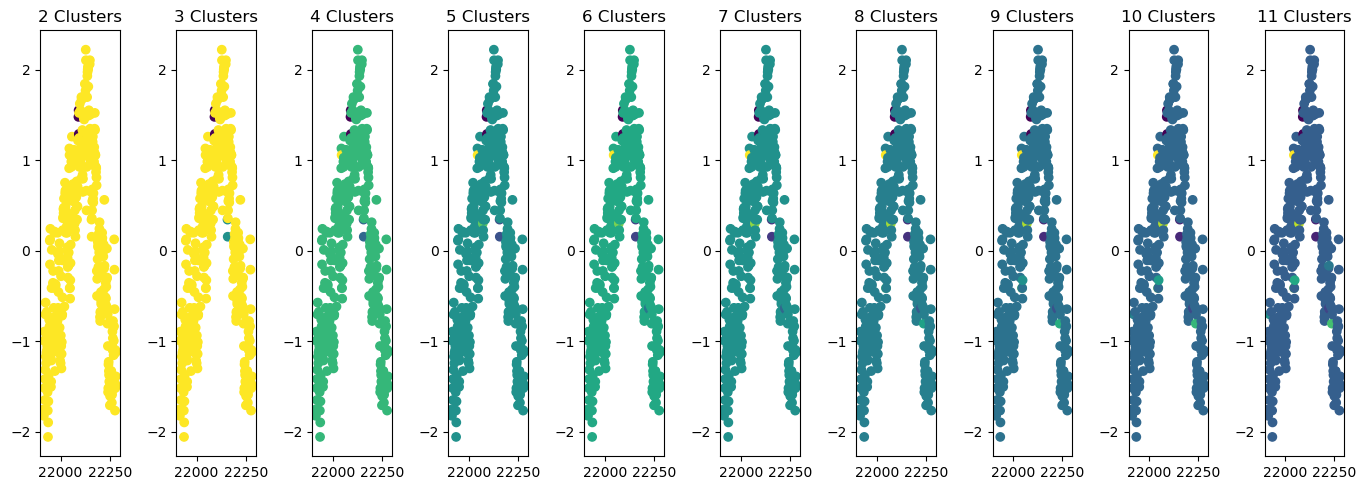

In [64]:
#Plot out distribution of clusters from the complete linkage method
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
for i, n_clusters in enumerate([2,3,4,5,6,7,8,9,10,11], 1):
    plt.subplot(1,11,i)
    plt.scatter(temp_scaled_SM.index, temp_scaled_SM.iloc[:,0], c=temp_scaled_SM[f'clust{n_clusters}'], cmap='viridis')
    plt.title(f'{n_clusters} Clusters')
plt.tight_layout()
plt.show()

In [66]:
#Use silhouette method to see if a certain number of clusters could be more optimized
from sklearn.metrics import silhouette_score

for n_clusters in [2,3,4,5,6,7,8,9,10,11]:
    score_1= silhouette_score(temp_scaled, temp_scaled_SM[f'clust{n_clusters}'])
    print(f"Silhouette score for {n_clusters} clusters: {score_1:.3f}")

Silhouette score for 2 clusters: 0.206
Silhouette score for 3 clusters: -0.044
Silhouette score for 4 clusters: -0.172
Silhouette score for 5 clusters: -0.271
Silhouette score for 6 clusters: -0.437
Silhouette score for 7 clusters: -0.443
Silhouette score for 8 clusters: -0.455
Silhouette score for 9 clusters: -0.455
Silhouette score for 10 clusters: -0.476
Silhouette score for 11 clusters: -0.480


In [97]:
temp_scaled_CM = temp_scaled.copy()

temp_scaled_CM['clust2']=fcluster(distance_complete_temp,2, criterion='maxclust')
temp_scaled_CM['clust3']=fcluster(distance_complete_temp,3, criterion='maxclust')

temp_scaled_CM.head(1)

,BASEL_temp_mean,BELGRADE_temp_mean,BUDAPEST_temp_mean,DEBILT_temp_mean,DUSSELDORF_temp_mean,HEATHROW_temp_mean,KASSEL_temp_mean,LJUBLJANA_temp_mean,MAASTRICHT_temp_mean,MADRID_temp_mean,MUNCHENB_temp_mean,OSLO_temp_mean,SONNBLICK_temp_mean,STOCKHOLM_temp_mean,VALENTIA_temp_mean,BASEL_pleasant_weather,BELGRADE_pleasant_weather,BUDAPEST_pleasant_weather,DEBILT_pleasant_weather,DUSSELDORF_pleasant_weather,HEATHROW_pleasant_weather,KASSEL_pleasant_weather,LJUBLJANA_pleasant_weather,MAASTRICHT_pleasant_weather,MADRID_pleasant_weather,MUNCHENB_pleasant_weather,OSLO_pleasant_weather,SONNBLICK_pleasant_weather,STOCKHOLM_pleasant_weather,VALENTIA_pleasant_weather,clust2,clust3
21915,-1.822856,-1.532505,-1.199888,-1.95823,-1.783855,-1.381399,1.776357e-15,-1.684889,-2.074051,-1.265753,-1.467275,-1.056845,-0.462869,-0.982295,-3.552714e-15,-0.681175,-0.724569,-0.742191,-0.545777,-0.600495,-0.617359,0.0,-0.702764,-0.592076,-0.916076,-0.613139,-0.447214,0.0,-0.516174,0.0,2,2


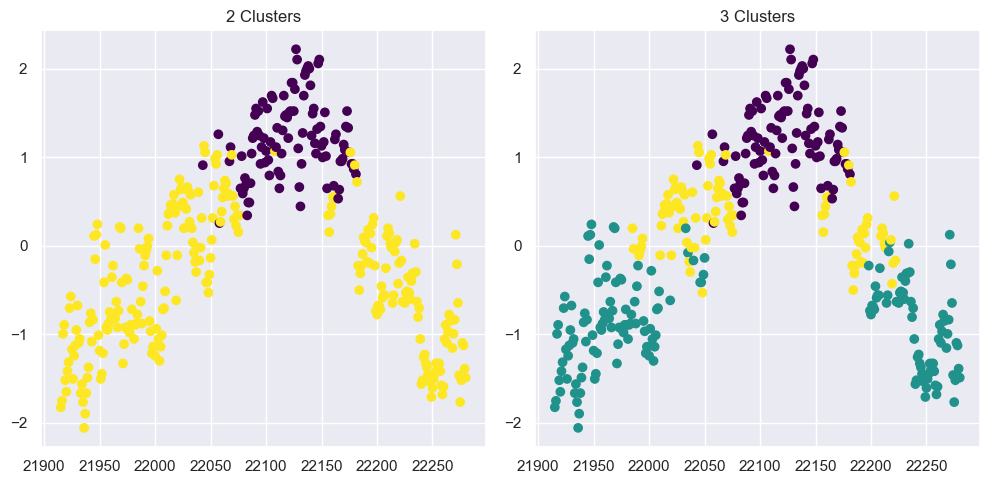

In [267]:
#Plot out distribution of clusters from the complete linkage method
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
for i, n_clusters in enumerate([2,3], 1):
    plt.subplot(1,3,i)
    plt.scatter(temp_scaled_CM.index, temp_scaled_CM.iloc[:,0], c=temp_scaled_CM[f'clust{n_clusters}'], cmap='viridis')
    plt.title(f'{n_clusters} Clusters')
plt.tight_layout()
plt.show()

In [115]:
#Use silhouette method to see if a certain number of clusters could be more optimized
from sklearn.metrics import silhouette_score

for n_clusters in [2,3]:
    score_2= silhouette_score(temp_scaled, temp_scaled_CM[f'clust{n_clusters}'])
    print(f"Silhouette score for {n_clusters} clusters: {score_2:.3f}")

Silhouette score for 2 clusters: 0.371
Silhouette score for 3 clusters: 0.299


In [101]:
temp_scaled_AM = temp_scaled.copy()

temp_scaled_AM['clust2']=fcluster(distance_average_temp,2, criterion='maxclust')
temp_scaled_AM['clust3']=fcluster(distance_average_temp,3, criterion='maxclust')
temp_scaled_AM['clust4']=fcluster(distance_average_temp,4, criterion='maxclust')

temp_scaled_AM.head(1)

,BASEL_temp_mean,BELGRADE_temp_mean,BUDAPEST_temp_mean,DEBILT_temp_mean,DUSSELDORF_temp_mean,HEATHROW_temp_mean,KASSEL_temp_mean,LJUBLJANA_temp_mean,MAASTRICHT_temp_mean,MADRID_temp_mean,MUNCHENB_temp_mean,OSLO_temp_mean,SONNBLICK_temp_mean,STOCKHOLM_temp_mean,VALENTIA_temp_mean,BASEL_pleasant_weather,BELGRADE_pleasant_weather,BUDAPEST_pleasant_weather,DEBILT_pleasant_weather,DUSSELDORF_pleasant_weather,HEATHROW_pleasant_weather,KASSEL_pleasant_weather,LJUBLJANA_pleasant_weather,MAASTRICHT_pleasant_weather,MADRID_pleasant_weather,MUNCHENB_pleasant_weather,OSLO_pleasant_weather,SONNBLICK_pleasant_weather,STOCKHOLM_pleasant_weather,VALENTIA_pleasant_weather,clust2,clust3,clust4
21915,-1.822856,-1.532505,-1.199888,-1.95823,-1.783855,-1.381399,1.776357e-15,-1.684889,-2.074051,-1.265753,-1.467275,-1.056845,-0.462869,-0.982295,-3.552714e-15,-0.681175,-0.724569,-0.742191,-0.545777,-0.600495,-0.617359,0.0,-0.702764,-0.592076,-0.916076,-0.613139,-0.447214,0.0,-0.516174,0.0,1,1,1


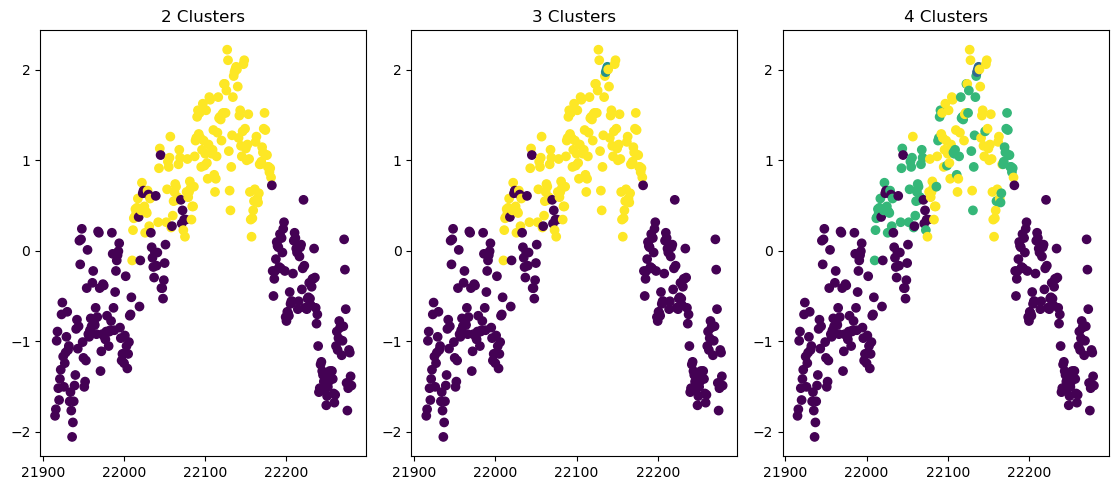

In [103]:
#Plot out distribution of clusters from the complete linkage method
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
for i, n_clusters in enumerate([2,3,4], 1):
    plt.subplot(1,4,i)
    plt.scatter(temp_scaled_AM.index, temp_scaled_AM.iloc[:,0], c=temp_scaled_AM[f'clust{n_clusters}'], cmap='viridis')
    plt.title(f'{n_clusters} Clusters')
plt.tight_layout()
plt.show()

In [117]:
#Use silhouette method to see if a certain number of clusters could be more optimized
from sklearn.metrics import silhouette_score

for n_clusters in [2,3,4]:
    score_3= silhouette_score(temp_scaled, temp_scaled_AM[f'clust{n_clusters}'])
    print(f"Silhouette score for {n_clusters} clusters: {score_3:.3f}")

Silhouette score for 2 clusters: 0.440
Silhouette score for 3 clusters: 0.365
Silhouette score for 4 clusters: 0.372


In [105]:
temp_scaled_WM = temp_scaled.copy()

temp_scaled_WM['clust2']=fcluster(distance_ward_temp,2, criterion='maxclust')

temp_scaled_WM.head(1)

,BASEL_temp_mean,BELGRADE_temp_mean,BUDAPEST_temp_mean,DEBILT_temp_mean,DUSSELDORF_temp_mean,HEATHROW_temp_mean,KASSEL_temp_mean,LJUBLJANA_temp_mean,MAASTRICHT_temp_mean,MADRID_temp_mean,MUNCHENB_temp_mean,OSLO_temp_mean,SONNBLICK_temp_mean,STOCKHOLM_temp_mean,VALENTIA_temp_mean,BASEL_pleasant_weather,BELGRADE_pleasant_weather,BUDAPEST_pleasant_weather,DEBILT_pleasant_weather,DUSSELDORF_pleasant_weather,HEATHROW_pleasant_weather,KASSEL_pleasant_weather,LJUBLJANA_pleasant_weather,MAASTRICHT_pleasant_weather,MADRID_pleasant_weather,MUNCHENB_pleasant_weather,OSLO_pleasant_weather,SONNBLICK_pleasant_weather,STOCKHOLM_pleasant_weather,VALENTIA_pleasant_weather,clust2
21915,-1.822856,-1.532505,-1.199888,-1.95823,-1.783855,-1.381399,1.776357e-15,-1.684889,-2.074051,-1.265753,-1.467275,-1.056845,-0.462869,-0.982295,-3.552714e-15,-0.681175,-0.724569,-0.742191,-0.545777,-0.600495,-0.617359,0.0,-0.702764,-0.592076,-0.916076,-0.613139,-0.447214,0.0,-0.516174,0.0,2


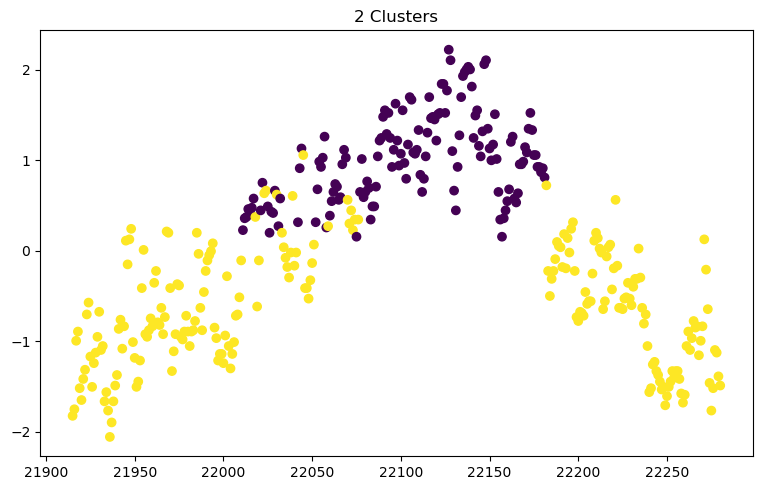

In [107]:
#Plot out distribution of clusters from the complete linkage method
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
for i, n_clusters in enumerate([2], 1):
    plt.subplot(1,2,i)
    plt.scatter(temp_scaled_WM.index, temp_scaled_WM.iloc[:,0], c=temp_scaled_WM[f'clust{n_clusters}'], cmap='viridis')
    plt.title(f'{n_clusters} Clusters')
plt.tight_layout()
plt.show()

In [121]:
#Use silhouette method to see if a certain number of clusters could be more optimized
from sklearn.metrics import silhouette_score

for n_clusters in [2]:
    score_4= silhouette_score(temp_scaled, temp_scaled_WM[f'clust{n_clusters}'])
    print(f"Silhouette score for {n_clusters} clusters: {score_4:.3f}")

Silhouette score for 2 clusters: 0.440


#### Oslo / Valentia Clusters

In [133]:
osva_scaled_WM = osva_scaled.copy()

osva_scaled_WM['clust2']=fcluster(distance_ward_osva,2, criterion='maxclust')

osva_scaled_WM.head(1)

,OSLO_cloud_cover,OSLO_wind_speed,OSLO_humidity,OSLO_pressure,OSLO_global_radiation,OSLO_precipitation,OSLO_snow_depth,OSLO_sunshine,OSLO_temp_mean,OSLO_temp_min,OSLO_temp_max,VALENTIA_cloud_cover,VALENTIA_humidity,VALENTIA_pressure,VALENTIA_global_radiation,VALENTIA_precipitation,VALENTIA_snow_depth,VALENTIA_sunshine,VALENTIA_temp_mean,VALENTIA_temp_min,VALENTIA_temp_max,OSLO_pleasant_weather,VALENTIA_pleasant_weather,clust2
21915,0.69066,-0.555486,0.431902,0.547607,-1.03018,-0.491171,-0.167124,-1.104558,-1.056845,-1.185486,-1.161203,0.0,-1.110223e-16,-2.220446e-16,4.440892e-16,-5.551115e-17,0.0,8.881784e-16,-3.552714e-15,0.0,0.0,-0.447214,0.0,1


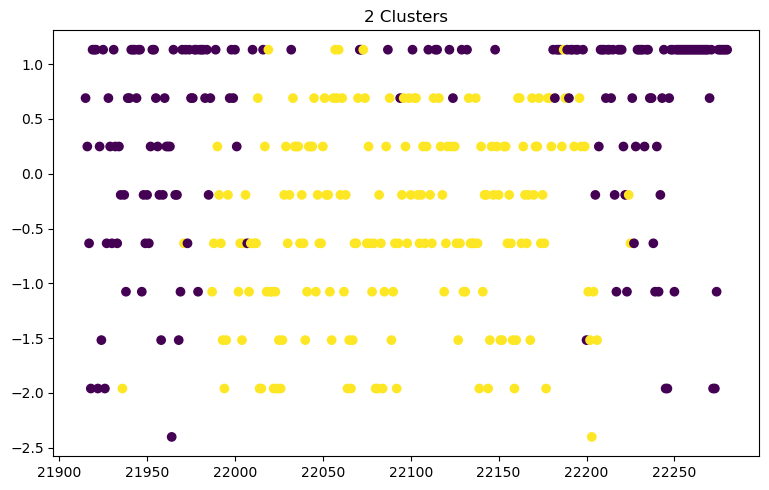

In [135]:
#Plot out distribution of clusters from the complete linkage method
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
for i, n_clusters in enumerate([2], 1):
    plt.subplot(1,2,i)
    plt.scatter(osva_scaled_WM.index, osva_scaled_WM.iloc[:,0], c=osva_scaled_WM[f'clust{n_clusters}'], cmap='viridis')
    plt.title(f'{n_clusters} Clusters')
plt.tight_layout()
plt.show()

In [145]:
#Use silhouette method to see if a certain number of clusters could be more optimized
from sklearn.metrics import silhouette_score

for n_clusters in [2]:
    score_5= silhouette_score(osva_scaled, osva_scaled_WM[f'clust{n_clusters}'])
    print(f"Silhouette score for {n_clusters} clusters: {score_5:.3f}")

Silhouette score for 2 clusters: 0.255


#### Oslo / Stockholme Clusters

In [139]:
osst_scaled_WM = osst_scaled.copy()

osst_scaled_WM['clust2']=fcluster(distance_ward_osst,2, criterion='maxclust')

osst_scaled_WM.head(1)

,OSLO_cloud_cover,OSLO_wind_speed,OSLO_humidity,OSLO_pressure,OSLO_global_radiation,OSLO_precipitation,OSLO_snow_depth,OSLO_sunshine,OSLO_temp_mean,OSLO_temp_min,OSLO_temp_max,STOCKHOLM_cloud_cover,STOCKHOLM_pressure,STOCKHOLM_global_radiation,STOCKHOLM_precipitation,STOCKHOLM_sunshine,STOCKHOLM_temp_mean,STOCKHOLM_temp_min,STOCKHOLM_temp_max,OSLO_pleasant_weather,STOCKHOLM_pleasant_weather,clust2
21915,0.69066,-0.555486,0.431902,0.547607,-1.03018,-0.491171,-0.167124,-1.104558,-1.056845,-1.185486,-1.161203,0.0,0.204439,0.304158,-0.418918,-1.088664,-0.982295,-0.98549,-1.054877,-0.447214,-0.516174,1


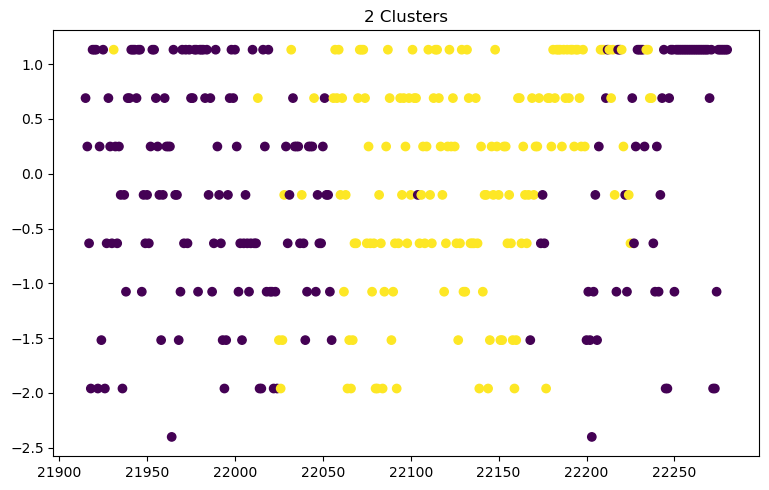

In [141]:
#Plot out distribution of clusters from the complete linkage method
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
for i, n_clusters in enumerate([2], 1):
    plt.subplot(1,2,i)
    plt.scatter(osst_scaled_WM.index, osst_scaled_WM.iloc[:,0], c=osst_scaled_WM[f'clust{n_clusters}'], cmap='viridis')
    plt.title(f'{n_clusters} Clusters')
plt.tight_layout()
plt.show()

In [143]:
#Use silhouette method to see if a certain number of clusters could be more optimized
from sklearn.metrics import silhouette_score

for n_clusters in [2]:
    score_6= silhouette_score(osst_scaled, osst_scaled_WM[f'clust{n_clusters}'])
    print(f"Silhouette score for {n_clusters} clusters: {score_6:.3f}")

Silhouette score for 2 clusters: 0.237


### After reviewing all of the cluster distributions from the dendrogram linkage methods as well as their associated silhouette scores, it seems that proceeding with a condensed data set that has a wider variety of weather stations (e.g. the 15 stations with just mean temps) provides more meaningful clustering information. Also, these clusters received some of the highest silhouette scores--including the Average & Ward linkage method of 2 clusters with a silhouette score of 0.44. For simplicity of the PCA, however, just an evaluation of Oslo / Valentia will be observed.

## 6. Run PCA - Oslo Only

In [146]:
df_oslo_2.shape

(366, 11)

In [126]:
scaled_features = StandardScaler().fit_transform(df_oslo_2)
scaled_features

array([[ 0.69066009, -0.55548553,  0.43190173, ..., -1.05684506,
        -1.18548609, -1.16120297],
       [ 0.24873423,  0.82170468,  0.66025281, ..., -0.71548695,
        -0.87821213, -0.84704728],
       [-0.6351175 ,  1.59637418, -0.53859035, ..., -0.65342183,
        -0.65629204, -0.74232872],
       ...,
       [ 1.13258595,  2.11282051,  1.00277942, ..., -0.99477995,
        -0.65629204, -1.305191  ],
       [ 1.13258595,  1.94067173,  1.05986719, ..., -1.08787762,
        -0.65629204, -1.31828082],
       [ 1.13258595, -0.38333676,  0.77442834, ..., -1.32062178,
        -0.91235368, -1.46226884]])

In [148]:
#Run the PCA model, reducing to 2 components
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(scaled_features)
principalComponents

array([[-2.15352855, -1.09679803],
       [-1.76552148, -0.62136973],
       [-1.04489501, -0.93297573],
       [-0.52990105, -2.73317312],
       [-2.58731563, -1.25021972],
       [-2.57557787, -0.4236244 ],
       [-2.20183156,  0.2055357 ],
       [-0.46061857, -1.10879471],
       [-2.02877963, -0.97151746],
       [-1.4002145 , -2.60178694],
       [-2.86101026, -0.43475923],
       [-0.89867772, -1.88690322],
       [-2.15270926, -1.40470416],
       [-2.76781502,  0.3870392 ],
       [-1.88416419, -0.24206905],
       [-0.84217097, -0.66694223],
       [-3.0223095 ,  2.07025839],
       [-2.23871169, -0.35731354],
       [-0.73464498, -2.04387358],
       [-0.9866132 , -1.40576588],
       [-0.50741209, -0.98510019],
       [ 0.3122713 , -2.69312023],
       [-1.89073562, -1.64915238],
       [-0.71598819, -1.54994436],
       [-2.14331682, -1.05527899],
       [-2.14788071, -0.28529741],
       [-2.81292307,  1.07390414],
       [-3.15438836,  0.82737578],
       [-3.12866888,

In [150]:
#Make a dataframe of the new components
dfPCA = pd.DataFrame(principalComponents, columns=['PCA1', 'PCA2'])
dfPCA.head(1)

,PCA1,PCA2
0,-2.153529,-1.096798


In [162]:
#Add the weather ratings to the dataframe to show the relationship
ratings = pl_2[['OSLO_pleasant_weather']]
ratings.shape

(366, 1)

In [176]:
#reset index
ratings = ratings.reset_index()
ratings

,level_0,index,OSLO_pleasant_weather
0,0,21915,0
1,1,21916,0
2,2,21917,0
3,3,21918,0
4,4,21919,0
5,5,21920,0
6,6,21921,0
7,7,21922,0
8,8,21923,0
9,9,21924,0


In [180]:
dfPCA_3 = pd.concat([dfPCA, ratings], axis=1)
dfPCA_3.head(1)

,PCA1,PCA2,level_0,index,OSLO_pleasant_weather
0,-2.153529,-1.096798,0,21915,0


In [182]:
oslo_WM=dfPCA_3.copy()

oslo_WM['clust2']=fcluster(distance_ward_oslo,2, criterion='maxclust')
oslo_WM.head()

,PCA1,PCA2,level_0,index,OSLO_pleasant_weather,clust2
0,-2.153529,-1.096798,0,21915,0,2
1,-1.765521,-0.621370,1,21916,0,2
2,-1.044895,-0.932976,2,21917,0,2
3,-0.529901,-2.733173,3,21918,0,2
4,-2.587316,-1.250220,4,21919,0,2


<Axes: title={'center': 'Pleasant Weather Prediction'}, xlabel='PCA1', ylabel='PCA2'>

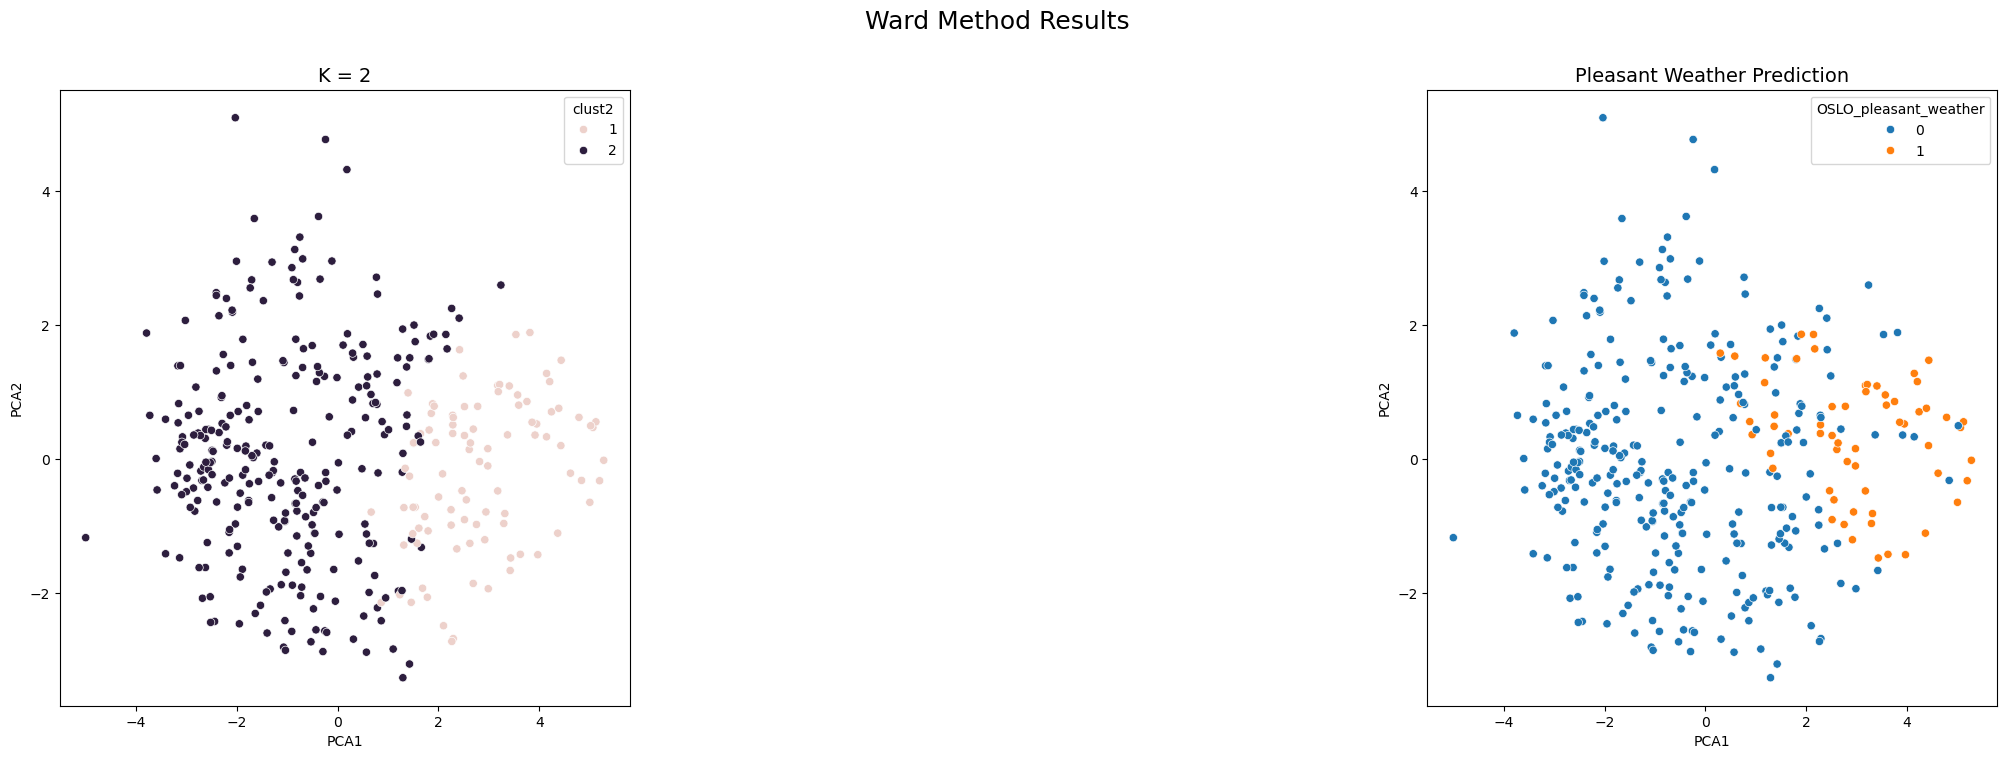

In [186]:
#plot the clusters against the answers
plt.figure(figsize=(25,8))

plt.suptitle("Ward Method Results",fontsize=18)

plt.subplot(1,3,1)
plt.title("K = 2",fontsize=14)
sns.scatterplot(x="PCA1",y="PCA2", data=oslo_WM, hue="clust2")

plt.subplot(1,3,3)
plt.title("Pleasant Weather Prediction",fontsize=14)
sns.scatterplot(x="PCA1",y="PCA2", data=oslo_WM, hue="OSLO_pleasant_weather")

In [246]:
df_temps.to_parquet(os.path.join(path,'01 Datasets', '02 Prepared Data', '02 Unsupervised', 'weather_means.parquet'))

In [248]:
df_osva.to_parquet(os.path.join(path, '01 Datasets', '02 Prepared Data', '02 Unsupervised', 'weather_osva.parquet'))

In [250]:
df_osst.to_parquet(os.path.join(path, '01 Datasets', '02 Prepared Data', '02 Unsupervised', 'weather_osst.parquet'))